# Weekly Assignment 8

# Prepations

In [1]:
#Ensure we are using the right kernel
spark.version

'3.1.3'

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

In [3]:
!pip uninstall -y nltk
!pip install nltk --upgrade --no-cache-dir

Found existing installation: nltk 3.6.4
Uninstalling nltk-3.6.4:
  Successfully uninstalled nltk-3.6.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.4 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 267.6 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4


In [4]:
import os
import shutil
import pandas as pd
# import sh
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *

In [5]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# GCP

In [6]:
from google.cloud import storage

# Timeer

In [7]:
import time

In [8]:
start = time.time()

#elapsed = (time.clock() - start)
#print(“Time used:”,elapsed)

# Get started

It takes too much time to run through all `parquet` files. So, we can start with only using one of them.

In [9]:
time0 = time.time()

In [10]:
dataPath = 'gs://msca-bdp-students-bucket/shared_data/hjiang248/final_sdf_v9_formatted_2'

In [11]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True) 

In [12]:
data = spark.read.parquet(dataPath)

In [13]:
elapsed = (time.time() - start)
print(f'Read data takes {elapsed} seconds')

Read data takes 6.056116580963135 seconds


# I. Similarity Test with MinHashLSH - Influencer (Celebrity or social media influencer) 

In [14]:
# filter gov and orginal content

celebrity = data.filter((data.organization == 'Celebrity_Influencer') & (data.retweeted != 'RT') & (data.text.isNotNull()))

In [15]:
celebrity = celebrity #.limit(10000)

## 1. Prep and Clean-up, remove stopwords and create index

Remove stopwords and create token, index

In [16]:
df_title_raw = celebrity.select(['text']) #.withColumnRenamed('title', 'text')
#df_title_raw.limit(5)

In [17]:
text = df_title_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
             .map( lambda document: document.strip().lower())\
             .map( lambda document: re.split(" ", document))\
             .map( lambda word: [x for x in word if x.isalnum()])\
             .map( lambda word: [x for x in word if x not in StopWords])\
             .map( lambda word: [x for x in word if len(x) > 3] )\
             .zipWithIndex()

In [18]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
#df_text.limit(5)

In [19]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
#df_tokens.limit(5).toPandas()

In [20]:
df_text.count()

5778

## 2. Fit countvectorizer to create word features

In [21]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [22]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[indonesian, teacher, found, guilty, raping, students, islamic, boarding, impregnated]",0,"(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[summer, start, seeking, colleges]",1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[current, recently, graduated, college, athletes, descended, texas, ahead]",2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[first, said, cops, campus, would, stop, school, arming, teachers, stop]",3,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[tamil, fresh, faceoff, government, moved, resolution, recently, announced]",4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


## 3. Fit MinHashLSH to create hash table

In [23]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize) #.cache()

In [24]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left') #.cache()
#df_hashed_text.limit(5)

## 4. Establish similarity threshold and return near-duplicate records

### Jaccard = 0.5

In [25]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [26]:
df_dups_50 = df_dups_text
#df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,994,2029,"(how i self-published 25 books before graduating college: https://t.co/l2gjmji2c5,)","(how i self-published 25 books before graduating college: https://t.co/l2gjmji2c5,)"
1,0.0,791,2178,"(four teachers, 135 students, and one giant classroom: arizona’s largest school system is embracing “team teaching”… https://t.co/5opik021pk,)","(four teachers, 135 students, and one giant classroom: arizona’s largest school system is embracing “team teaching”… https://t.co/weei14gfhm,)"
2,0.0,648,2029,"(how i self-published 25 books before graduating college: https://t.co/l2gjmji2c5,)","(how i self-published 25 books before graduating college: https://t.co/l2gjmji2c5,)"
3,0.0,788,2182,"(one hurdle in expanding access to higher-paid roles are existing — but sometimes unnecessary — requirements for col… https://t.co/irjomfhfqe,)","(one hurdle in expanding access to higher-paid roles are existing — but sometimes unnecessary — requirements for col… https://t.co/fhfl1qf5mh,)"
4,0.0,573,3218,"(only a third of higher education students report having a great university experience https://t.co/qlkctyosui,)","(only a third of higher education students report having a great university experience https://t.co/rxpwyn2416,)"


In [27]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  5778
Duplicate titles based on { 0.5 } jaccard distance:  528
Unique titles based on { 0.5 } jaccard distance:  0.5 :  5250


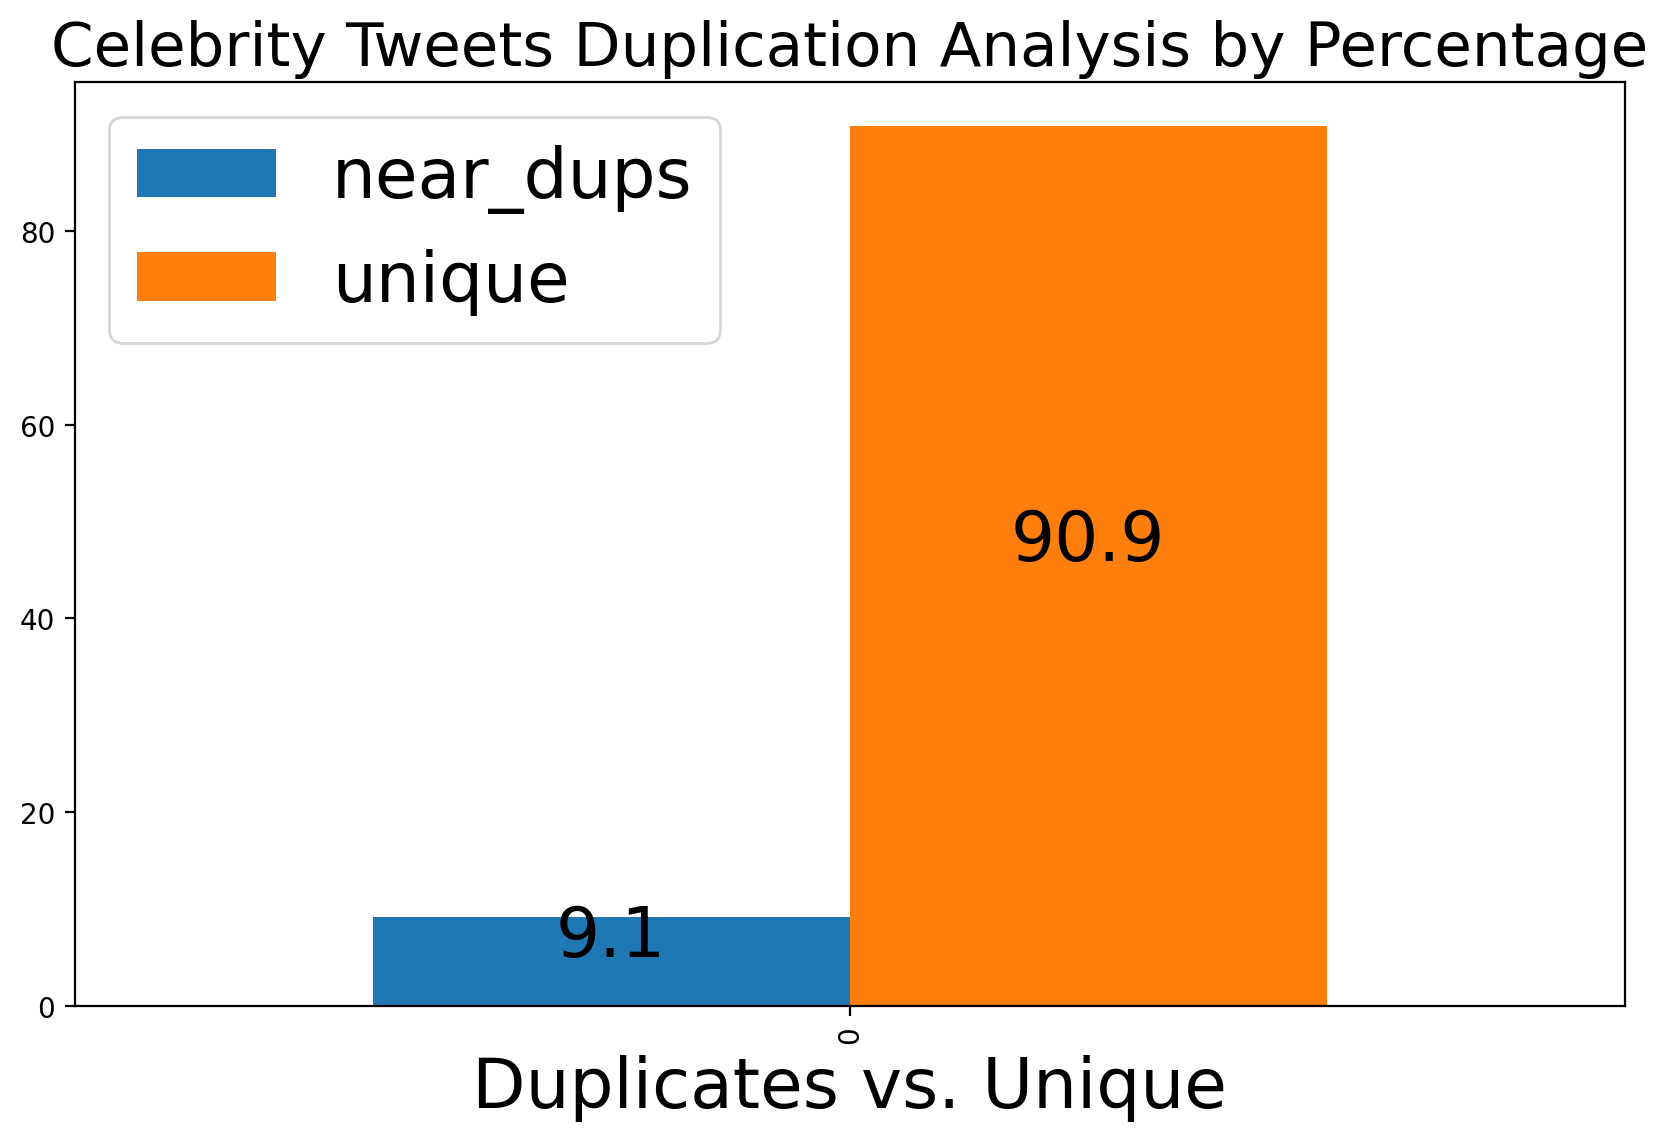

In [28]:
dups_ratio = dups/records*100
uniques_ratio = uniques/records*100
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_ratio], 'unique': [uniques_ratio]}).round(2)

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 25})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Celebrity Tweets Duplication Analysis by Percentage', fontsize=22)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [29]:
elapsed_1 = (time.time() - start)

# II. Similarity Test with MinHashLSH - Government_Entities

In [30]:
# filter gov and orginal content

Government_Entities = data.filter((data.organization == 'Government_Entities') & (data.retweeted != 'RT') & (data.text.isNotNull()))

In [31]:
Government_Entities = Government_Entities #.limit(10000)

## 1. Prep and Clean-up, remove stopwords and create index

Remove stopwords and create token, index

In [32]:
df_title_raw = Government_Entities.select(['text']) #.withColumnRenamed('title', 'text')
#df_title_raw.limit(5)

In [33]:
text = df_title_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
             .map( lambda document: document.strip().lower())\
             .map( lambda document: re.split(" ", document))\
             .map( lambda word: [x for x in word if x.isalnum()])\
             .map( lambda word: [x for x in word if x not in StopWords])\
             .map( lambda word: [x for x in word if len(x) > 3] )\
             .zipWithIndex()

In [34]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
#df_text.limit(5)

In [35]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
#df_tokens.limit(5).toPandas()

In [36]:
df_text.count()

3862

## 2. Fit countvectorizer to create word features

In [37]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [38]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[many, actually, received, hard, quantifiable, nearly, enough]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[defund, decertify, complex, return, funds, taxpayers]",1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[florida, student, accepted, colleges, including, earns, nearly, scholarships]",2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[looking, next, first, first, generation, college, student, passionate]",3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[signed, attend, event, passion, education, includes, tuition, free]",4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


## 3. Fit MinHashLSH to create hash table

In [39]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize) #.cache()

In [40]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left') #.cache()
#df_hashed_text.limit(5)

## 4. Establish similarity threshold and return near-duplicate records

### Jaccard = 0.5

In [41]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [42]:
df_dups_50 = df_dups_text
#df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.416667,2868,2987,"(congratulations to rio lindo elementary school for receiving an educational grant from the barona band of mission i… https://t.co/fklgmwg3gm,)","(congratulations to john adams elementary on receiving a $5,000 grant from the barona band of mission indians! the f… https://t.co/fk0bn0kyhl,)"
1,0.000000,1954,2785,"(my tremendous respect for and appreciation kindergarten teachers / early childhood educators continues to grow expo… https://t.co/2rgl6xmesf,)","(my tremendous respect and appreciation for kindergarten teachers / early childhood educators continues to grow expo… https://t.co/wcv5y5uc4e,)"
2,0.000000,2150,2301,"(some photos from last night's hoover high school hispanic heritage celebration! https://t.co/ij0ss4dof9,)","(some photos from last night's hoover high school hispanic heritage celebration! https://t.co/cimzr52ge6,)"
3,0.000000,1614,2457,"(teachers give a grand welcome to pm shri @narendramodi ji at ahmedabad as he arrives to launch #schoolofexcellence… https://t.co/4ioralrdns,)","(teachers give a grand welcome to pm shri @narendramodi ji at ahmedabad as he arrives to launch #schoolofexcellence… https://t.co/vfpyfnhz0o,)"
4,0.100000,982,986,"(the big act would empower schools and local communities with the resources necessary to ensure the safety and healt… https://t.co/yjkr76umln,)","(""this bill would empower schools and local communities with the resources necessary to ensure the safety and health… https://t.co/gx6bt3yutv,)"


In [43]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

#records_title[jaccard_distance] = [records, dups, uniques]

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3862
Duplicate titles based on { 0.5 } jaccard distance:  209
Unique titles based on { 0.5 } jaccard distance:  0.5 :  3653


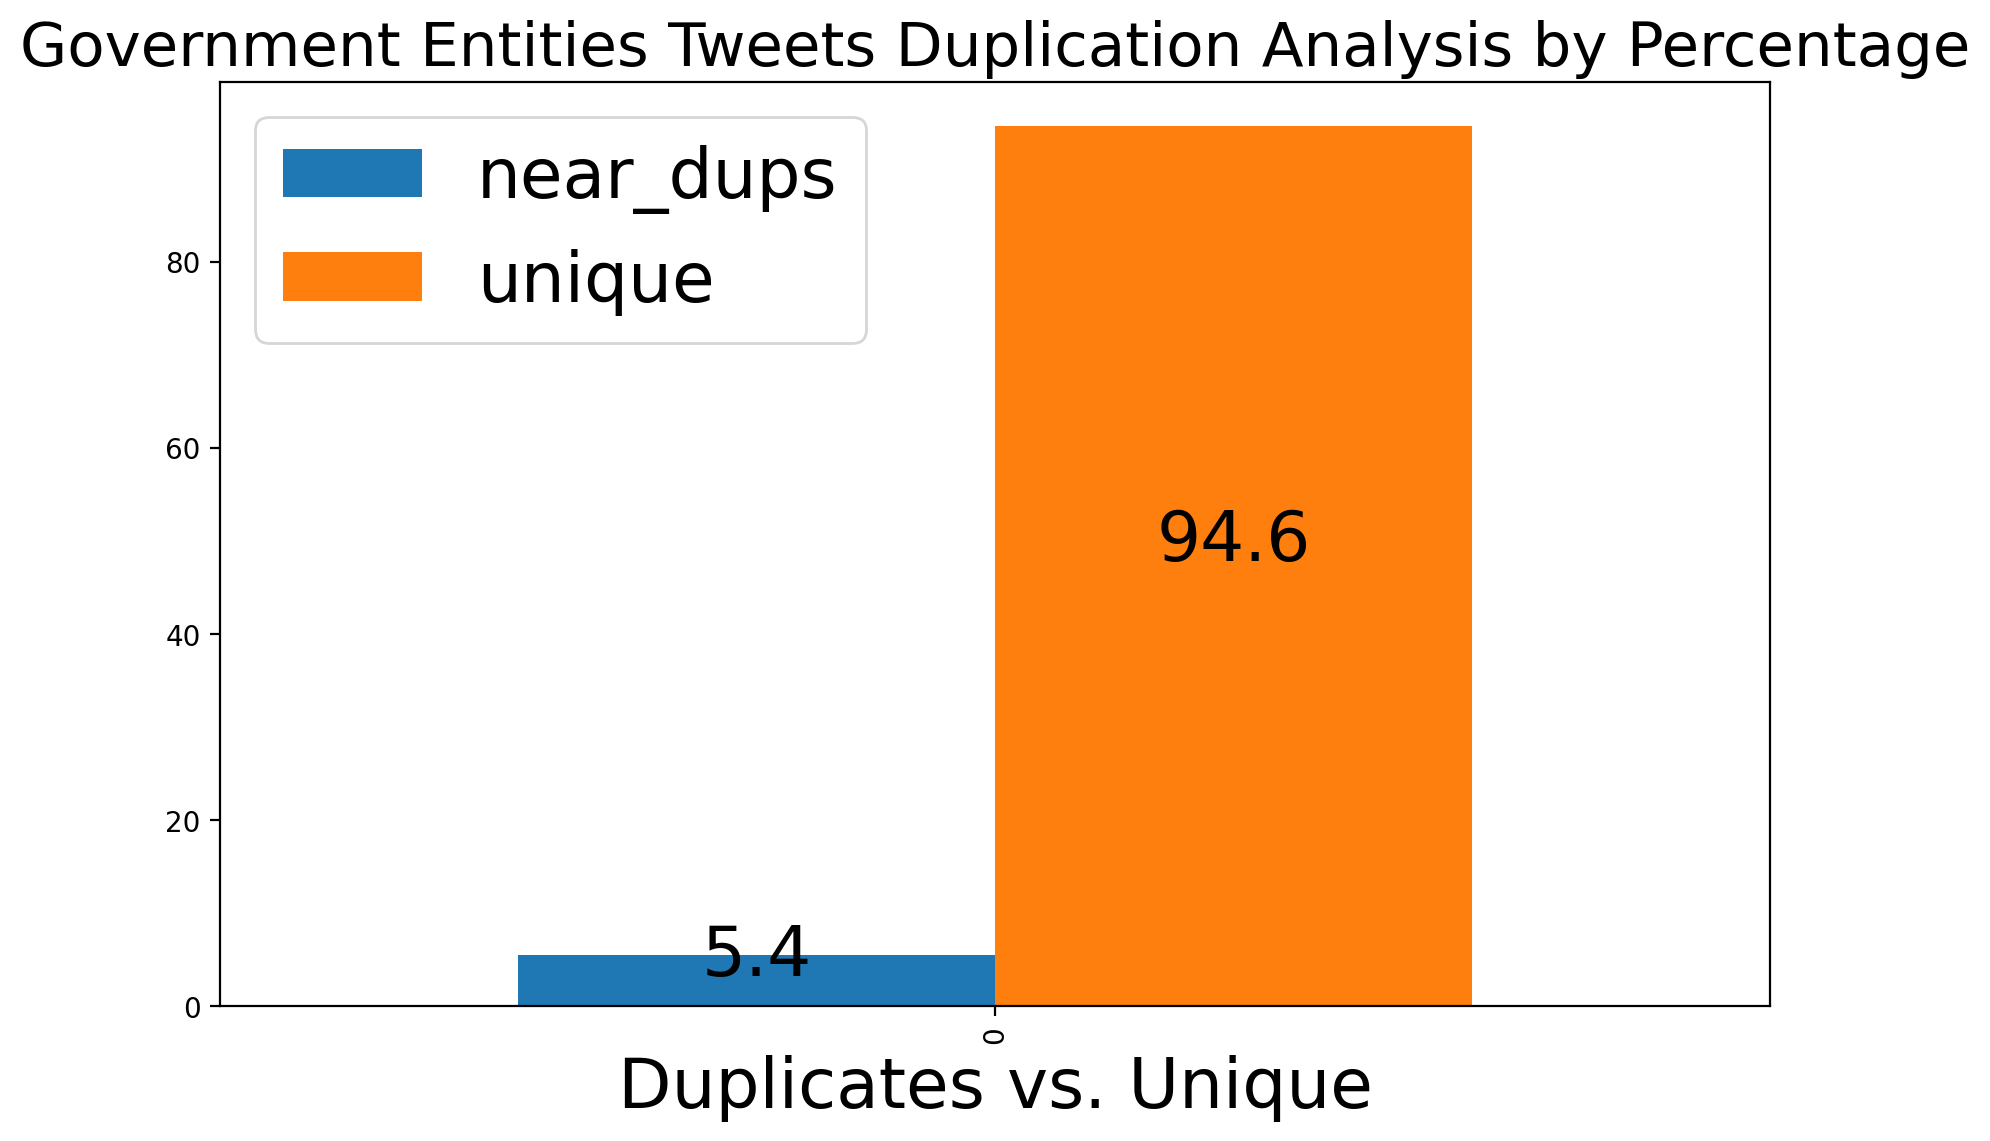

In [44]:
dups_ratio = dups/records*100
uniques_ratio = uniques/records*100
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_ratio], 'unique': [uniques_ratio]}).round(2)

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 25})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Government Entities Tweets Duplication Analysis by Percentage', fontsize=22)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

# III. Similarity Test with MinHashLSH - Universities

In [45]:
# filter gov and orginal content

universities = data.filter((data.organization == 'Universities') & (data.retweeted != 'RT') & (data.text.isNotNull()))

In [46]:
universities = universities #.limit(10000)

## 1. Prep and Clean-up, remove stopwords and create index

Remove stopwords and create token, index

In [47]:
df_title_raw = Government_Entities.select(['text']) #.withColumnRenamed('title', 'text')
#df_title_raw.limit(5)

In [48]:
text = df_title_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
             .map( lambda document: document.strip().lower())\
             .map( lambda document: re.split(" ", document))\
             .map( lambda word: [x for x in word if x.isalnum()])\
             .map( lambda word: [x for x in word if x not in StopWords])\
             .map( lambda word: [x for x in word if len(x) > 3] )\
             .zipWithIndex()

In [49]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
#df_text.limit(5)

In [50]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
#df_tokens.limit(5).toPandas()

In [51]:
df_text.count()

3862

## 2. Fit countvectorizer to create word features

In [52]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [53]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[many, actually, received, hard, quantifiable, nearly, enough]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[defund, decertify, complex, return, funds, taxpayers]",1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[florida, student, accepted, colleges, including, earns, nearly, scholarships]",2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[looking, next, first, first, generation, college, student, passionate]",3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[signed, attend, event, passion, education, includes, tuition, free]",4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


## 3. Fit MinHashLSH to create hash table

In [54]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize) #.cache()

In [55]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left') #.cache()
#df_hashed_text.limit(5)

## 4. Establish similarity threshold and return near-duplicate records

### Jaccard = 0.5

In [56]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [57]:
df_dups_50 = df_dups_text
#df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000000,733,1568,"(makhothatso matsela, a primary school teacher living with hiv from lesotho, shares her journey of battling cervical… https://t.co/kso2hwdgan,)","(makhothatso matsela, a primary school teacher living with hiv from lesotho, shares her journey of battling cervical… https://t.co/elqvanatcg,)"
1,0.285714,1079,3467,"(i’m working to fully fund our public schools. that’s what our students and teachers need.,)","(i’m fighting to fully fund our public schools. that’s what our students and teachers need.,)"
2,0.300000,1269,3421,"(my mom is a retired teacher. she shared a similar story of deciding to stand between students &amp; a shooter if needed… https://t.co/ko90pr7htn,)","(my mom is a retired teacher and told me a similar story of deciding to stand between her students and a shooter if… https://t.co/5ekqdve9us,)"
3,0.000000,2182,3512,"(i've proudly worked to support and build opportunities students, teachers and schools in #maine for over 30 years.… https://t.co/hturjpsw8j,)","(i've proudly worked to support and build opportunities for students, teachers and schools in #maine for over 30 yea… https://t.co/zhm7u87meh,)"
4,0.000000,3296,3297,"(parents &amp; guardians of kindergarteners: you can now activate your child’s new nyc scholarship account! here’s what… https://t.co/2z0uqcfghr,)","(parents &amp; guardians of kindergarteners: you can now activate your child’s new nyc scholarship account! here’s what… https://t.co/n2c2aruetp,)"


In [58]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  3862
Duplicate titles based on { 0.5 } jaccard distance:  208
Unique titles based on { 0.5 } jaccard distance:  0.5 :  3654


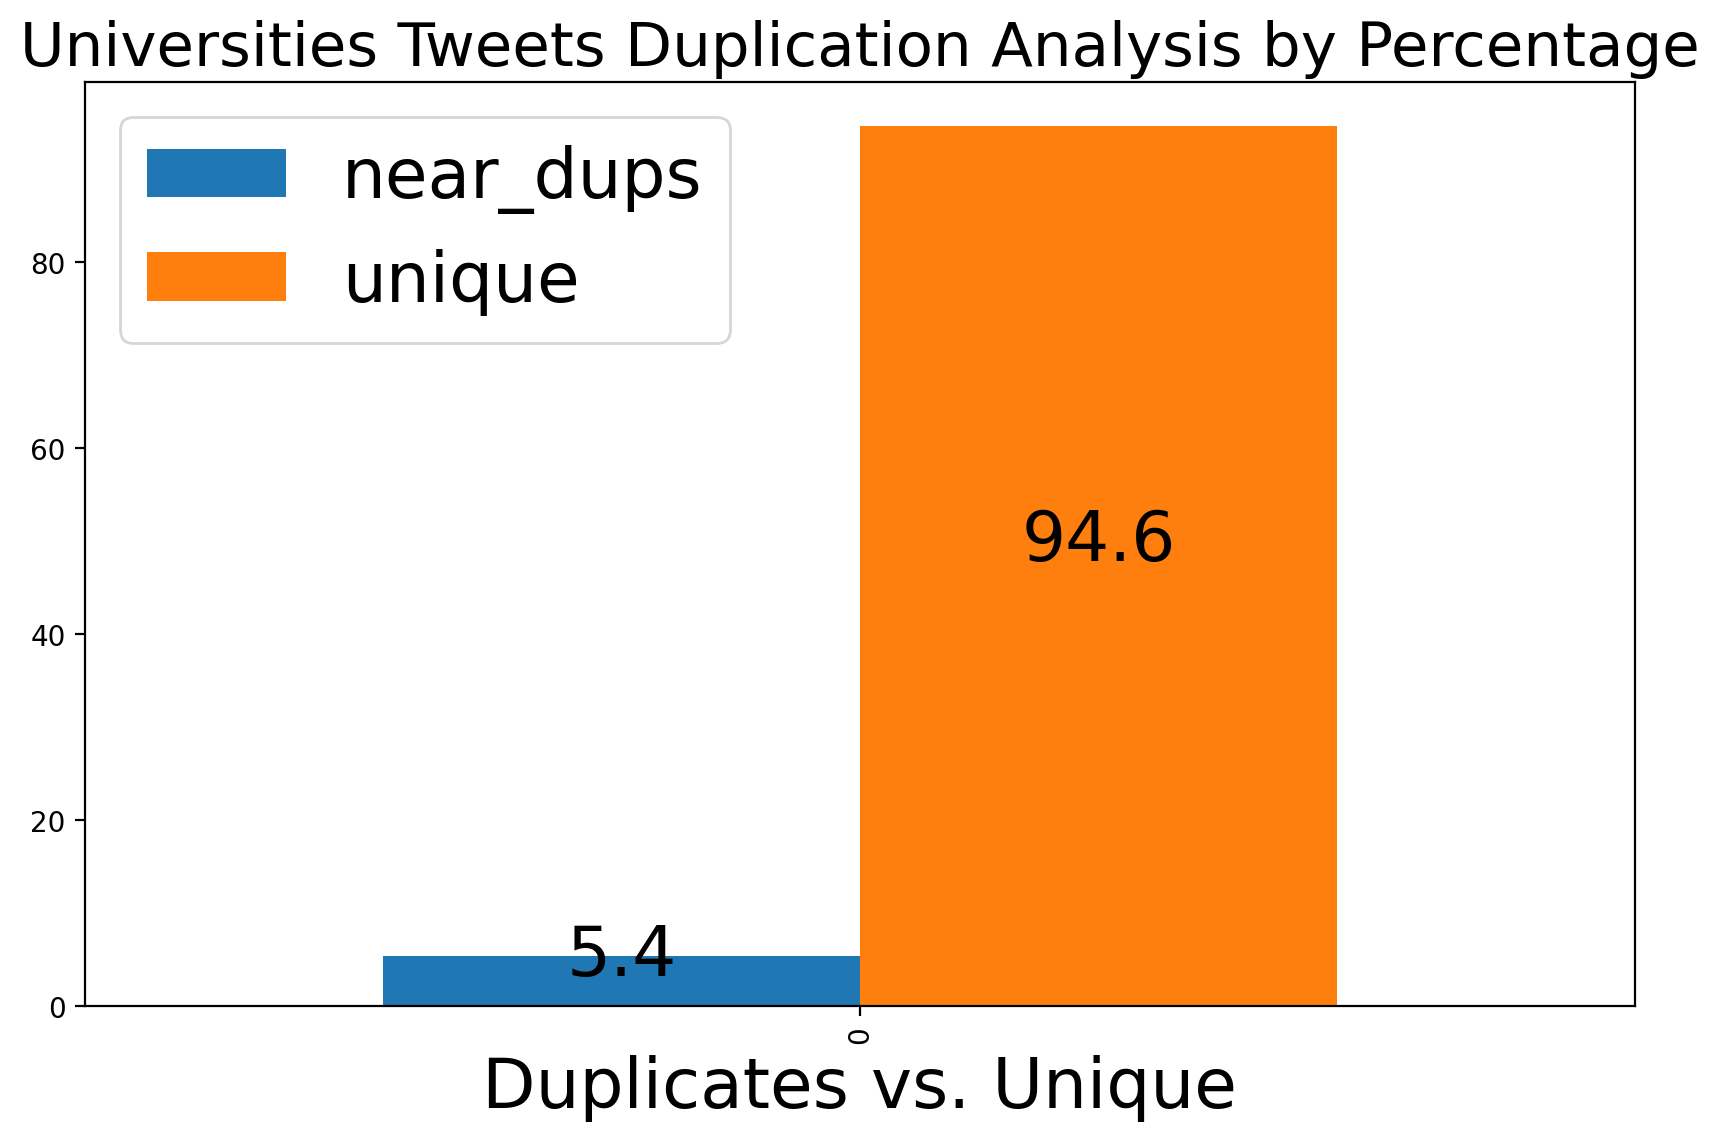

In [59]:
dups_ratio = dups/records*100
uniques_ratio = uniques/records*100
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_ratio], 'unique': [uniques_ratio]}).round(2)

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 25})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Universities Tweets Duplication Analysis by Percentage', fontsize=22)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

# IV. Similarity Test with MinHashLSH - Schools

In [60]:
# filter gov and orginal content

schools = data.filter((data.organization == 'Schools') & (data.retweeted != 'RT') & (data.text.isNotNull()))

In [61]:
schools = schools #.limit(10000)

## 1. Prep and Clean-up, remove stopwords and create index

Remove stopwords and create token, index

In [62]:
df_title_raw = schools.select(['text']) #.withColumnRenamed('title', 'text')
#df_title_raw.limit(5)

In [63]:
text = df_title_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
             .map( lambda document: document.strip().lower())\
             .map( lambda document: re.split(" ", document))\
             .map( lambda word: [x for x in word if x.isalnum()])\
             .map( lambda word: [x for x in word if x not in StopWords])\
             .map( lambda word: [x for x in word if len(x) > 3] )\
             .zipWithIndex()

In [64]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
#df_text.limit(5)

In [65]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
#df_tokens.limit(5).toPandas()

In [66]:
df_text.count()

381

## 2. Fit countvectorizer to create word features

In [67]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [68]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[terrific, idea, floated, invest, college, programs, scholarship, limit]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[tennessee, high, school, high, school, assistant, director]",1,"(2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[maryland, basketball, head, coach, brenda, frese, received, contract, extension, school]",2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,[recently],3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[teachers, react, texas, school, shooting]",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


## 3. Fit MinHashLSH to create hash table

In [69]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize) #.cache()

In [70]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left') #.cache()
#df_hashed_text.limit(5)

## 4. Establish similarity threshold and return near-duplicate records

### Jaccard = 0.5

In [71]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [72]:
df_dups_50 = df_dups_text
#df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000000,313,374,"(the hdsb is providing literacy and mathematics resources for families of kindergarten - grade 12 students to suppor… https://t.co/rm3ass1ovl,)","(the hdsb is providing literacy and mathematics resources for families of kindergarten - grade 12 students to suppor… https://t.co/10nspei40b,)"
1,0.444444,83,167,"(@westpointhigh vs. @russellvillek12. watch this boys football regular season game live on the #nfhsnetwork!… https://t.co/al1lpituzi,)","(@russellvillek12 vs. @bpatriotsports. watch this girls volleyball regular season game live on the #nfhsnetwork!… https://t.co/wo4w7jcopx,)"
2,0.142857,83,362,"(@westpointhigh vs. @russellvillek12. watch this boys football regular season game live on the #nfhsnetwork!… https://t.co/al1lpituzi,)","(@skhsrebels vs. @nss_k12. watch this football regular season game live on the #nfhsnetwork! \n\n@skhsri_rebels |… https://t.co/bwfwisprul,)"
3,0.454545,41,143,"(mid-penn receiving leaders through the second week of the high school football season https://t.co/dwlwcvlt6e,)","(kansas high school passing, rushing and receiving top 5 stat leaders for 11-player football through week 4… https://t.co/dinrcawwiq,)"
4,0.333333,197,241,"(@wethersfieldk12 vs. manchester. watch this football regular season game between wethersfield and manchester live o… https://t.co/wcqfolfjja,)","(@cps_k12 vs. flint. watch this boys football regular season game live on the #nfhsnetwork! \n\nhttps://t.co/aqw0pay8fh,)"


In [73]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

#records_title[jaccard_distance] = [records, dups, uniques]

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  381
Duplicate titles based on { 0.5 } jaccard distance:  59
Unique titles based on { 0.5 } jaccard distance:  0.5 :  322


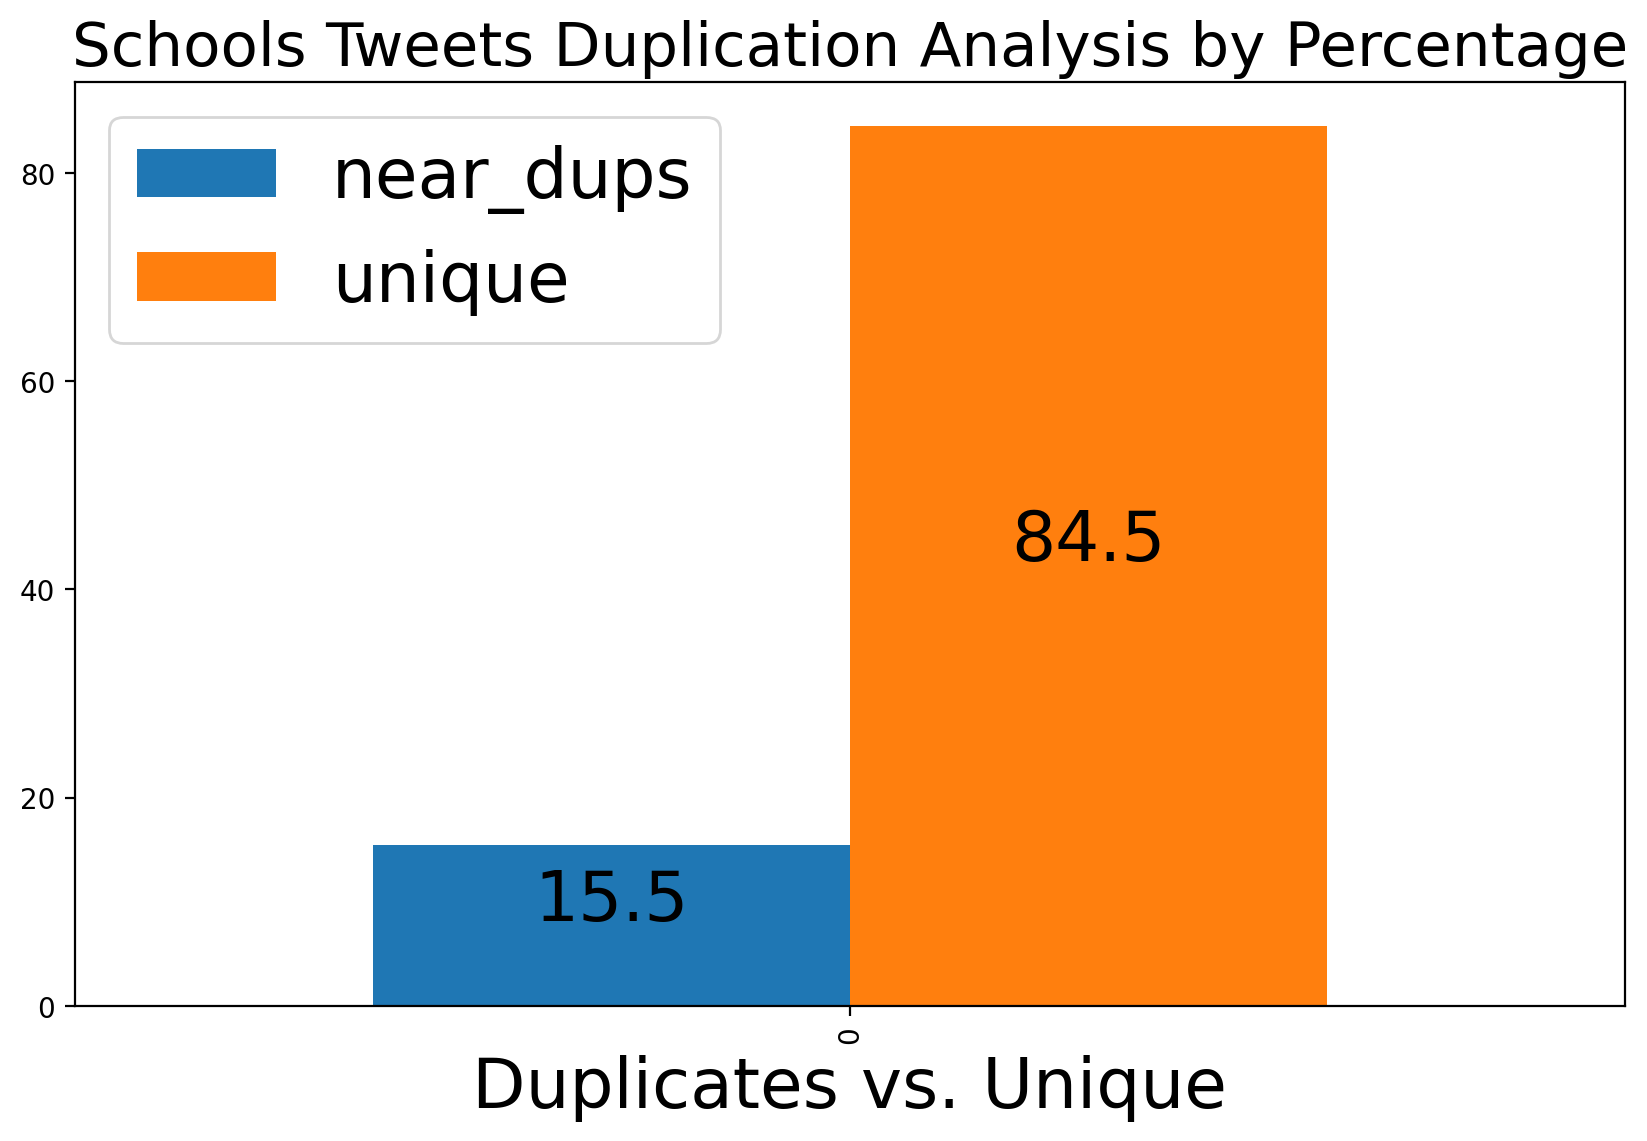

In [74]:
dups_ratio = dups/records*100
uniques_ratio = uniques/records*100
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_ratio], 'unique': [uniques_ratio]}).round(2)

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 25})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Schools Tweets Duplication Analysis by Percentage', fontsize=22)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

# V. Similarity Test with MinHashLSH - NGOs

In [75]:
# filter gov and orginal content

NGO = data.filter((data.organization == 'NGOs') & (data.retweeted != 'RT') & (data.text.isNotNull()))

In [76]:
NGO = NGO #.limit(10000)

## 1. Prep and Clean-up, remove stopwords and create index

Remove stopwords and create token, index

In [77]:
df_title_raw = NGO.select(['text']) #.withColumnRenamed('title', 'text')
#df_title_raw.limit(5)

In [78]:
text = df_title_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
             .map( lambda document: document.strip().lower())\
             .map( lambda document: re.split(" ", document))\
             .map( lambda word: [x for x in word if x.isalnum()])\
             .map( lambda word: [x for x in word if x not in StopWords])\
             .map( lambda word: [x for x in word if len(x) > 3] )\
             .zipWithIndex()

In [79]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
#df_text.limit(5)

In [80]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
#df_tokens.limit(5).toPandas()

In [81]:
df_text.count()

1432

## 2. Fit countvectorizer to create word features

In [82]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [83]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[colorado, needs, preschool, free, college, classes]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[announce, tomorrow, receiving, alumni, award, excellence, film, school]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[topic, debate, recent, months, types, books, schools, include, libraries]",2,"(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[survey, provides, districts, information, experiences]",3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[feedback, needs, recognize, commitment, making, difference, writes]",4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


## 3. Fit MinHashLSH to create hash table

In [84]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize) #.cache()

In [85]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left') #.cache()
#df_hashed_text.limit(5)

## 4. Establish similarity threshold and return near-duplicate records

### Jaccard = 0.5

In [86]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [87]:
df_dups_50 = df_dups_text
#df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000000,64,222,"(a recent study looks at the long term benefits of early childhood education. perhaps unsurprisingly, the better k-1… https://t.co/cf2e3gjunq,)","(a recent study looks at the long term benefits of early childhood education. perhaps unsurprisingly, the better k-1… https://t.co/dnmzddc4yi,)"
1,0.000000,530,1032,"(missing from all of the recent energy and attention to culture-war-related school issues is a concerted focus on du… https://t.co/wq8mjykcqt,)","(missing from all of the recent energy and attention to culture-war-related school issues is a concerted focus on du… https://t.co/arswp17qd0,)"
2,0.000000,110,255,"(the department for education has recently published the updated 2022 ‘keeping children safe in education’ statutory… https://t.co/arqoasjqvc,)","(the department for education has recently published the updated 2022 ‘keeping children safe in education’ statutory… https://t.co/hdkcpitmya,)"
3,0.333333,174,501,"(how do teachers spend their time? to find out, @mq_mcshane surveyed a national sample of 686 public, charter, and p… https://t.co/yxvjiror7r,)","(how do teachers spend their time? to find out, mike mcshane surveyed a national sample of 686 public, charter and p… https://t.co/mfvus1sqtj,)"
4,0.000000,736,1003,"(colorado college student talks neurodiversity, mentorship, and advocacy https://t.co/kk03mk2gwv https://t.co/rm2l6j2nlc,)","(colorado college student talks neurodiversity, mentorship, and advocacy https://t.co/ymwl7hofc0 https://t.co/vnwkzgqxur,)"


In [88]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

#records_title[jaccard_distance] = [records, dups, uniques]

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  1432
Duplicate titles based on { 0.5 } jaccard distance:  167
Unique titles based on { 0.5 } jaccard distance:  0.5 :  1265


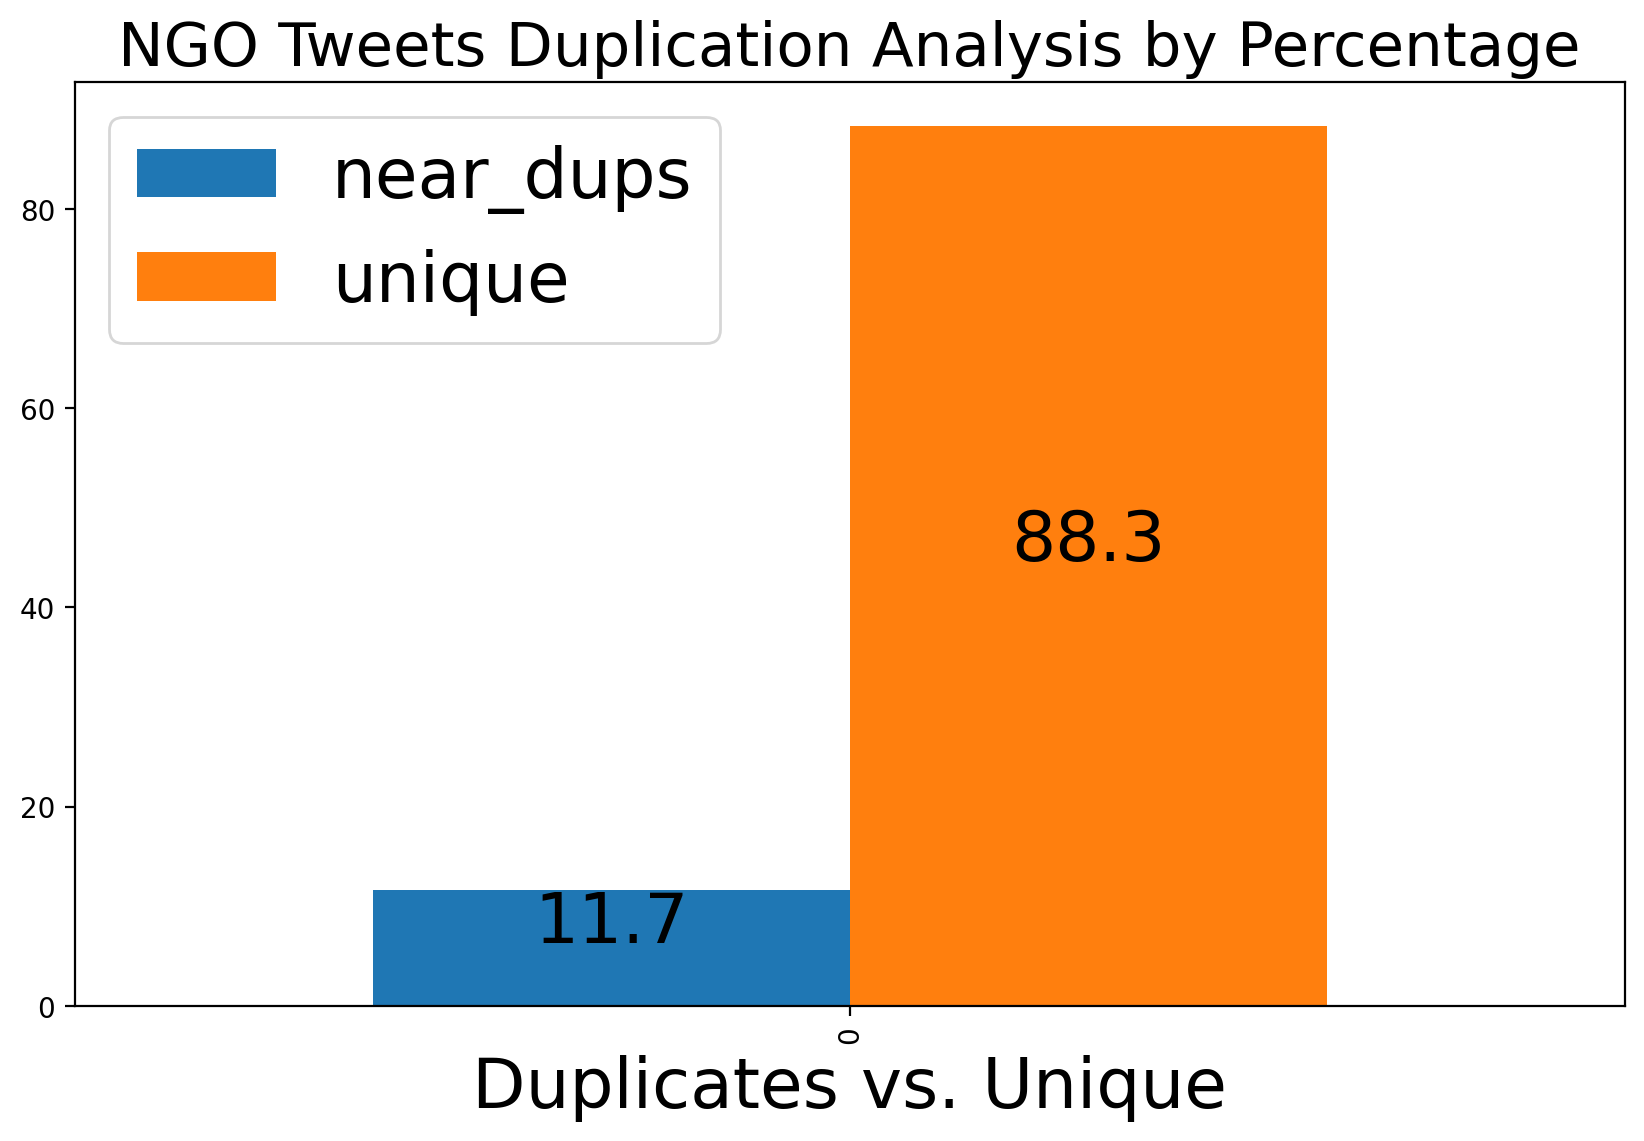

In [89]:
dups_ratio = dups/records*100
uniques_ratio = uniques/records*100
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_ratio], 'unique': [uniques_ratio]}).round(2)

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 25})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('NGO Tweets Duplication Analysis by Percentage', fontsize=22)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

# VI. Similarity Test with MinHashLSH - News & Media

In [90]:
# filter gov and orginal content

news = data.filter((data.organization == 'News_Media') & (data.retweeted != 'RT') & (data.text.isNotNull()))

In [91]:
news = news #.limit(10000)

## 1. Prep and Clean-up, remove stopwords and create index

Remove stopwords and create token, index

In [92]:
df_title_raw = news.select(['text']) #.withColumnRenamed('title', 'text')
#df_title_raw.limit(5)

In [93]:
text = df_title_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
             .map( lambda document: document.strip().lower())\
             .map( lambda document: re.split(" ", document))\
             .map( lambda word: [x for x in word if x.isalnum()])\
             .map( lambda word: [x for x in word if x not in StopWords])\
             .map( lambda word: [x for x in word if len(x) > 3] )\
             .zipWithIndex()

In [94]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
#df_text.limit(5)

In [95]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
#df_tokens.limit(5).toPandas()

In [96]:
df_text.count()

35185

## 2. Fit countvectorizer to create word features

In [97]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [98]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[classes, school, officials, ribbon, symbolic, opening, limited, classes]",0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[school, grade, teacher, married]",1,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[always, enjoyed, especially]",2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[recent, govt, came, scheme, give, month, girl]",3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[schools, limping, staggering, number, students, teachers]",4,"(0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


## 3. Fit MinHashLSH to create hash table

In [99]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize) #.cache()

In [100]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left') #.cache()
#df_hashed_text.limit(5)

## 4. Establish similarity threshold and return near-duplicate records

### Jaccard = 0.5

In [101]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
            )

In [102]:
df_dups_50 = df_dups_text
#df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000,12107,19503,"(the 19-year-old gunman who killed a teacher and a 15-year-old girl at a st. louis high school was armed with an ar-… https://t.co/narh6hdxu8,)","(the 19-year-old gunman who killed a teacher and a 15-year-old girl at a st. louis high school was armed with an ar-… https://t.co/q7axoqxnjj,)"
1,0.000,24457,30592,"(the 19-year-old gunman who killed a teacher and a 15-year-old girl at a st. louis high school was armed with an ar-… https://t.co/xc3fgix57q,)","(the 19-year-old gunman who killed a teacher and a 15-year-old girl at a st. louis high school was armed with an ar-… https://t.co/eg9jvh5rhh,)"
2,0.000,1143,24457,"(the 19-year-old gunman who killed a teacher and a 15-year-old girl at a st. louis high school was armed with an ar-… https://t.co/7trzs2oqes,)","(the 19-year-old gunman who killed a teacher and a 15-year-old girl at a st. louis high school was armed with an ar-… https://t.co/xc3fgix57q,)"
3,0.125,13291,25683,"(a 19-year-old who killed a teacher and a 15-year-old girl at a st. louis high school was armed with an ar-15-style… https://t.co/zzaxxsdh44,)","(the 19-year-old gunman who killed a teacher and a 15-year-old girl at a st. louis high school was armed with an ar-… https://t.co/u5n6kssjqn,)"
4,0.000,7200,17054,"(the 19-year-old gunman who killed a teacher and a 15-year-old girl at a st. louis high school was armed with an ar-… https://t.co/zbtet9cvh9,)","(the 19-year-old gunman who killed a teacher and a 15-year-old girl at a st. louis high school was armed with an ar-… https://t.co/qiqchwifd0,)"


In [103]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

#records_title[jaccard_distance] = [records, dups, uniques]

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  35185
Duplicate titles based on { 0.5 } jaccard distance:  7511
Unique titles based on { 0.5 } jaccard distance:  0.5 :  27674


In [104]:
dups_df.round(2)

,near_dups,unique
0,11.66,88.34


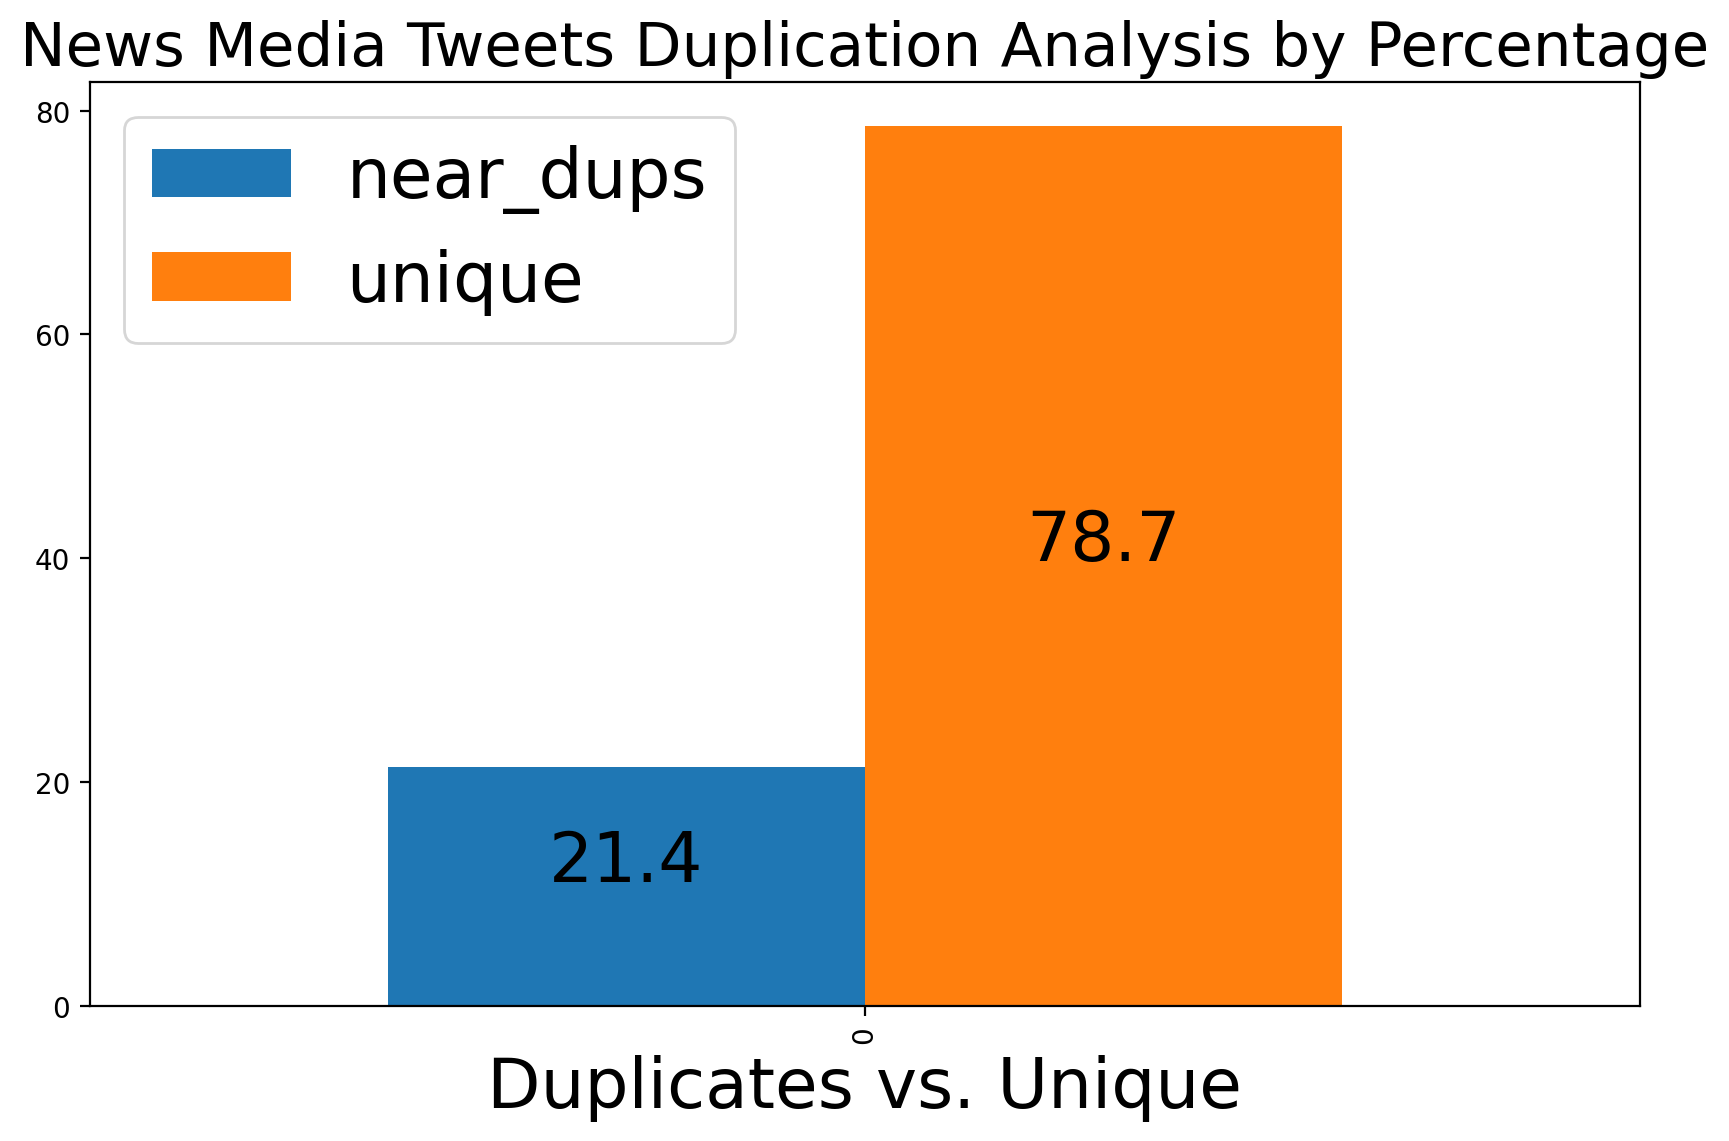

In [105]:
dups_ratio = dups/records*100
uniques_ratio = uniques/records*100
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_ratio], 'unique': [uniques_ratio]}).round(2)

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 25})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News Media Tweets Duplication Analysis by Percentage', fontsize=22)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [106]:
time6 = time.time()

In [107]:
exc_time = (time6 - time0) / 60
print(f'Execution time is: {exc_time} minutes')

Execution time is: 15.763795022169749 minutes
